# Phase 4: Feature Engineering

This notebook creates derived features and defines feature sets for the diabetes prediction models.

## Objectives
1. Create derived features with clinical/scientific rationale
2. Validate feature calculations (distributions, edge cases)
3. Define feature sets (with_labs, without_labs)
4. Prepare final datasets for modeling

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from features.builders import (
    create_all_derived_features,
    get_feature_sets,
    validate_feature_availability,
    prepare_modeling_data,
    create_all_modeling_datasets
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Paths
DATA_INTERIM = project_root / 'data' / 'interim'
DATA_PROCESSED = project_root / 'data' / 'processed'
FIGURES_DIR = project_root / 'reports' / 'figures'

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
print(f"Project root: {project_root}")

Project root: /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project


## 1. Load Cleaned Data

We load the minimal imputation dataset (preserves NaN for tree models).

In [2]:
# Load the cleaned data
df = pd.read_parquet(DATA_INTERIM / 'cleaned_minimal_impute.parquet')
print(f"Loaded data: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
print(f"\nTarget distribution:")
print(df['DIABETES_STATUS'].value_counts().sort_index())

Loaded data: 11,723 rows, 1,562 columns

Target distribution:
DIABETES_STATUS
0.0    5684
1.0    3795
2.0    2219
Name: count, dtype: int64


## 2. Create Derived Features

### 2.1 Feature Creation Overview

| Feature | Formula | Clinical Rationale |
|---------|---------|--------------------|
| AVG_SYS_BP | mean(BPXSY1-3) | Averages multiple readings for stability |
| AVG_DIA_BP | mean(BPXDI1-3) | Averages multiple readings for stability |
| TOTAL_WATER | sum(water columns) | Hydration affects glucose regulation |
| ACR_RATIO | albumin/creatinine | Early kidney damage marker |
| WEIGHT_CHANGE_10YR | current - 10yr ago | Weight gain trajectory |
| WEIGHT_CHANGE_25 | current - age 25 | Lifetime weight gain |
| WEIGHT_FROM_MAX | max - current | Weight loss from peak |
| WAKE_TIME_DIFF | weekend - weekday | Social jet lag affects metabolism |
| WAIST_HEIGHT_RATIO | waist / height | Central obesity measure |
| SAT_FAT_PCT | sat_fat / total_fat | Dietary fat quality |

In [3]:
# Create all derived features
df_feat, feature_stats = create_all_derived_features(df)

print(f"\nShape after feature engineering: {df_feat.shape}")
print(f"New columns: {df_feat.shape[1] - df.shape[1]}")

2026-02-01 21:43:23,458 - INFO - ============================================================


2026-02-01 21:43:23,459 - INFO - Creating derived features


2026-02-01 21:43:23,459 - INFO - ============================================================


2026-02-01 21:43:23,504 - INFO - Created AVG_SYS_BP: mean=125.8, n_valid=10700


2026-02-01 21:43:23,509 - INFO - Created AVG_DIA_BP: mean=70.9, n_valid=10700


2026-02-01 21:43:23,626 - INFO - Created TOTAL_WATER: mean=2385.1g, n_valid=10138


2026-02-01 21:43:23,713 - INFO - Created ACR_RATIO: median=0.1, abnormal (≥30): 0.2%


2026-02-01 21:43:23,781 - INFO - Created WEIGHT_CHANGE_10YR: mean=3.2kg, gained: 40.1%


2026-02-01 21:43:23,783 - INFO - Created WEIGHT_CHANGE_25: mean=13.1kg, gained: 62.4%


2026-02-01 21:43:23,785 - INFO - Created WEIGHT_FROM_MAX: mean=7.6kg, at/above max: 16.2%


2026-02-01 21:43:23,935 - INFO - Created WAKE_TIME_DIFF: mean=0.98hrs, later on weekends: 53.0%


2026-02-01 21:43:24,034 - INFO - Created SLQ310_HOURS (weekday wake): mean=6.8h, before 6am: 29.5%


2026-02-01 21:43:24,078 - INFO - Created SLQ330_HOURS (weekend wake): mean=7.8h, after 8am: 33.4%


2026-02-01 21:43:24,127 - INFO - Created WAIST_HEIGHT_RATIO: mean=0.597, >0.5: 73.9%


2026-02-01 21:43:24,174 - INFO - Created SAT_FAT_PCT: mean=32.0%, n_valid=10134


2026-02-01 21:43:24,218 - INFO - Created PULSE_PRESSURE: mean=54.9mmHg, >60mmHg: 30.1%


2026-02-01 21:43:24,261 - INFO - Created MAP: mean=89.2mmHg, >100mmHg: 16.8%


2026-02-01 21:43:24,321 - INFO - Created BP_VARIABILITY: mean=3.1mmHg, >10mmHg: 1.1%


2026-02-01 21:43:24,382 - INFO - Created CARB_FIBER_RATIO: mean=19.0, >15 (poor): 52.4%


2026-02-01 21:43:24,448 - INFO - Created SUGAR_CARB_RATIO: mean=41.3%


2026-02-01 21:43:24,524 - INFO - Created PHQ9_SCORE: mean=3.2, moderate+ (≥10): 8.6%


2026-02-01 21:43:24,584 - INFO - Created TG_HDL_RATIO: mean=2.5, >3.0 (IR): 24.5%


2026-02-01 21:43:24,648 - INFO - Created NON_HDL_CHOL: mean=134.9mg/dL, ≥160 (high): 25.0%


2026-02-01 21:43:24,709 - INFO - Created ANY_CVD: 11.3% have CVD history


2026-02-01 21:43:24,783 - INFO - Created SLEEP_DURATION_DIFF: mean=0.69hrs, more on weekends: 39.0%


2026-02-01 21:43:24,789 - INFO - ============================================================


2026-02-01 21:43:24,789 - INFO - Created 22 derived features


2026-02-01 21:43:24,790 - INFO - ============================================================



Shape after feature engineering: (11723, 1584)
New columns: 22


In [4]:
# Summary of created features
feature_summary = pd.DataFrame([
    {
        'Feature': name,
        'N Valid': stats.get('n_valid', 0),
        'Mean': stats.get('mean', np.nan),
        'Median': stats.get('median', np.nan),
        'Min': stats.get('range', [np.nan, np.nan])[0],
        'Max': stats.get('range', [np.nan, np.nan])[1]
    }
    for name, stats in feature_stats.items()
])

print("\nDerived Feature Summary:")
display(feature_summary)


Derived Feature Summary:


,Feature,N Valid,Mean,Median,Min,Max
0,AVG_SYS_BP,10700,125.786012,123.000000,72.666667,238.000000
1,AVG_DIA_BP,10700,70.865265,71.333333,0.000000,142.000000
2,TOTAL_WATER,10138,2385.120779,1800.000000,0.000000,30720.000000
3,ACR_RATIO,10757,0.512415,0.074436,-0.225000,211.521739
4,WEIGHT_CHANGE_10YR,7569,3.230993,3.240224,-126.933920,88.217520
5,WEIGHT_CHANGE_25,8900,13.089233,11.789360,-126.903760,129.202000
6,WEIGHT_FROM_MAX,10830,7.623010,4.825008,-61.163200,129.201880
7,WAKE_TIME_DIFF,5714,0.976622,0.500000,-19.000000,20.000000
8,SLQ310_HOURS,11642,6.774389,6.500000,0.000000,23.500000
9,SLQ330_HOURS,5747,7.794559,7.750000,0.000000,23.000000


## 3. Validate Derived Features

For each feature, we check:
- Distribution shape (histogram)
- Relationship with target
- Edge cases and outliers

### 3.1 Blood Pressure Averages

**Clinical Context:**
- Normal: <120/<80 mmHg
- Elevated: 120-129/<80
- Hypertension Stage 1: 130-139/80-89
- Hypertension Stage 2: ≥140/≥90

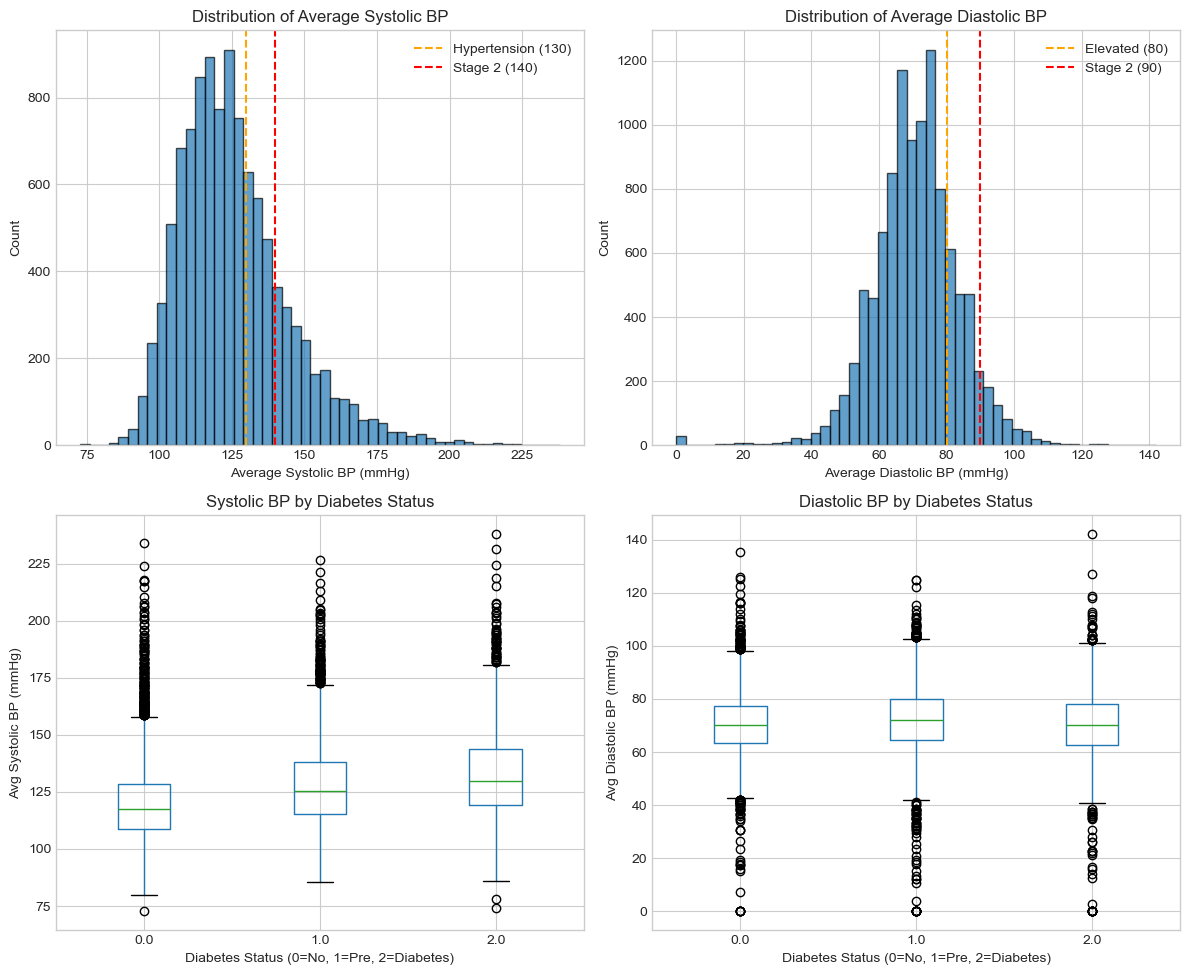


Mean BP by Diabetes Status:
                 AVG_SYS_BP  AVG_DIA_BP
DIABETES_STATUS                        
0.0                   120.8        70.5
1.0                   128.2        72.0
2.0                   133.3        69.9


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Systolic BP distribution
ax = axes[0, 0]
df_feat['AVG_SYS_BP'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(130, color='orange', linestyle='--', label='Hypertension (130)')
ax.axvline(140, color='red', linestyle='--', label='Stage 2 (140)')
ax.set_xlabel('Average Systolic BP (mmHg)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Average Systolic BP')
ax.legend()

# Diastolic BP distribution
ax = axes[0, 1]
df_feat['AVG_DIA_BP'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(80, color='orange', linestyle='--', label='Elevated (80)')
ax.axvline(90, color='red', linestyle='--', label='Stage 2 (90)')
ax.set_xlabel('Average Diastolic BP (mmHg)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Average Diastolic BP')
ax.legend()

# Systolic by diabetes status
ax = axes[1, 0]
df_feat.boxplot(column='AVG_SYS_BP', by='DIABETES_STATUS', ax=ax)
ax.set_xlabel('Diabetes Status (0=No, 1=Pre, 2=Diabetes)')
ax.set_ylabel('Avg Systolic BP (mmHg)')
ax.set_title('Systolic BP by Diabetes Status')
plt.suptitle('')

# Diastolic by diabetes status
ax = axes[1, 1]
df_feat.boxplot(column='AVG_DIA_BP', by='DIABETES_STATUS', ax=ax)
ax.set_xlabel('Diabetes Status (0=No, 1=Pre, 2=Diabetes)')
ax.set_ylabel('Avg Diastolic BP (mmHg)')
ax.set_title('Diastolic BP by Diabetes Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_bp_validation.png', bbox_inches='tight')
plt.show()

# Statistics by diabetes status
print("\nMean BP by Diabetes Status:")
print(df_feat.groupby('DIABETES_STATUS')[['AVG_SYS_BP', 'AVG_DIA_BP']].mean().round(1))

### 3.2 ACR Ratio (Kidney Function)

**Clinical Context:**
- Normal: <30 mg/g
- Microalbuminuria (early kidney damage): 30-299 mg/g
- Macroalbuminuria (overt kidney disease): ≥300 mg/g

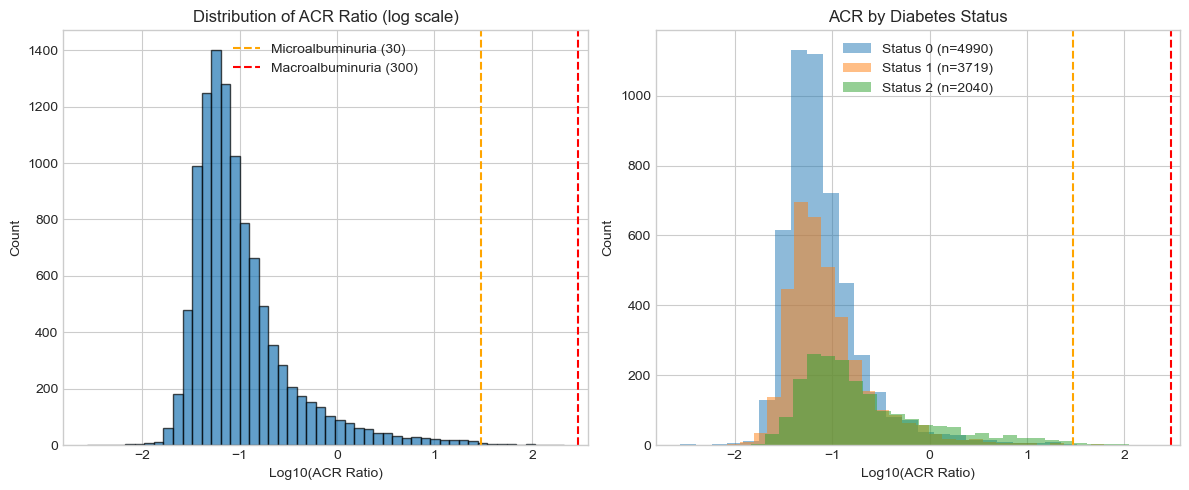


ACR Categories by Diabetes Status:
ACR_RATIO        Normal (<30)  Micro (30-299)
DIABETES_STATUS                              
0.0                      99.9             0.1
1.0                      99.9             0.1
2.0                      99.2             0.8


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACR distribution (log scale due to skew)
ax = axes[0]
acr_valid = df_feat['ACR_RATIO'].dropna()
acr_valid[acr_valid > 0].apply(np.log10).hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(np.log10(30), color='orange', linestyle='--', label='Microalbuminuria (30)')
ax.axvline(np.log10(300), color='red', linestyle='--', label='Macroalbuminuria (300)')
ax.set_xlabel('Log10(ACR Ratio)')
ax.set_ylabel('Count')
ax.set_title('Distribution of ACR Ratio (log scale)')
ax.legend()

# ACR by diabetes status
ax = axes[1]
acr_data = df_feat[['ACR_RATIO', 'DIABETES_STATUS']].dropna()
# Use log scale for visualization
for status in [0, 1, 2]:
    data = acr_data[acr_data['DIABETES_STATUS'] == status]['ACR_RATIO']
    ax.hist(np.log10(data[data > 0]), bins=30, alpha=0.5, 
            label=f'Status {status} (n={len(data)})')
ax.axvline(np.log10(30), color='orange', linestyle='--')
ax.axvline(np.log10(300), color='red', linestyle='--')
ax.set_xlabel('Log10(ACR Ratio)')
ax.set_ylabel('Count')
ax.set_title('ACR by Diabetes Status')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_acr_validation.png', bbox_inches='tight')
plt.show()

# ACR categories by diabetes status
print("\nACR Categories by Diabetes Status:")
acr_cat = pd.cut(df_feat['ACR_RATIO'], bins=[0, 30, 300, float('inf')], 
                 labels=['Normal (<30)', 'Micro (30-299)', 'Macro (≥300)'])
print(pd.crosstab(df_feat['DIABETES_STATUS'], acr_cat, normalize='index').round(3) * 100)

### 3.3 Weight Change Features

**Clinical Context:**
- Weight gain is a major modifiable risk factor for Type 2 diabetes
- Even modest weight loss (5-10%) can significantly reduce diabetes risk
- Weight trajectory matters: recent gain vs stable obesity

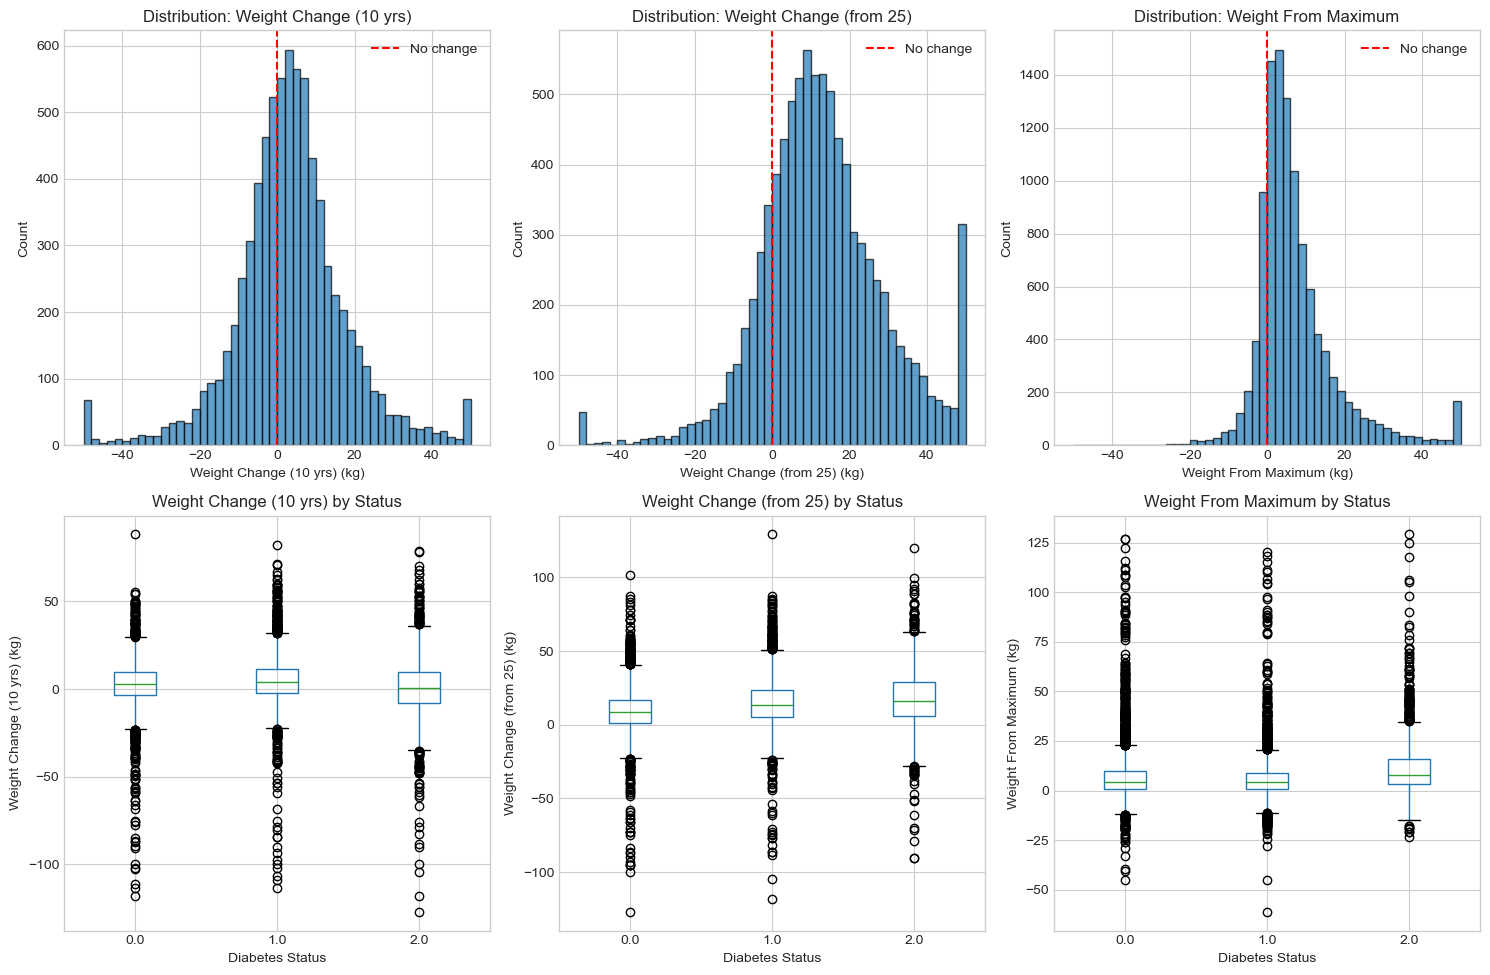


Weight Change Features by Diabetes Status (mean kg):
                 WEIGHT_CHANGE_10YR  WEIGHT_CHANGE_25  WEIGHT_FROM_MAX
DIABETES_STATUS                                                       
0.0                             2.7               9.2              7.1
1.0                             5.1              14.7              6.2
2.0                             1.1              17.6             11.4


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

weight_features = ['WEIGHT_CHANGE_10YR', 'WEIGHT_CHANGE_25', 'WEIGHT_FROM_MAX']
titles = ['Weight Change (10 yrs)', 'Weight Change (from 25)', 'Weight From Maximum']

for i, (feat, title) in enumerate(zip(weight_features, titles)):
    # Distribution
    ax = axes[0, i]
    data = df_feat[feat].dropna()
    # Clip extreme values for visualization
    data_clipped = data.clip(-50, 50)
    data_clipped.hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='No change')
    ax.set_xlabel(f'{title} (kg)')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution: {title}')
    ax.legend()
    
    # By diabetes status
    ax = axes[1, i]
    df_feat.boxplot(column=feat, by='DIABETES_STATUS', ax=ax)
    ax.set_xlabel('Diabetes Status')
    ax.set_ylabel(f'{title} (kg)')
    ax.set_title(f'{title} by Status')
    plt.suptitle('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_weight_change_validation.png', bbox_inches='tight')
plt.show()

# Statistics
print("\nWeight Change Features by Diabetes Status (mean kg):")
print(df_feat.groupby('DIABETES_STATUS')[weight_features].mean().round(1))

### 3.4 Waist-to-Height Ratio

**Clinical Context:**
- Simple rule: "Keep your waist less than half your height"
- Ratio >0.5: Increased cardiometabolic risk
- Ratio >0.6: Substantially increased risk
- Better predictor of diabetes than BMI for many populations

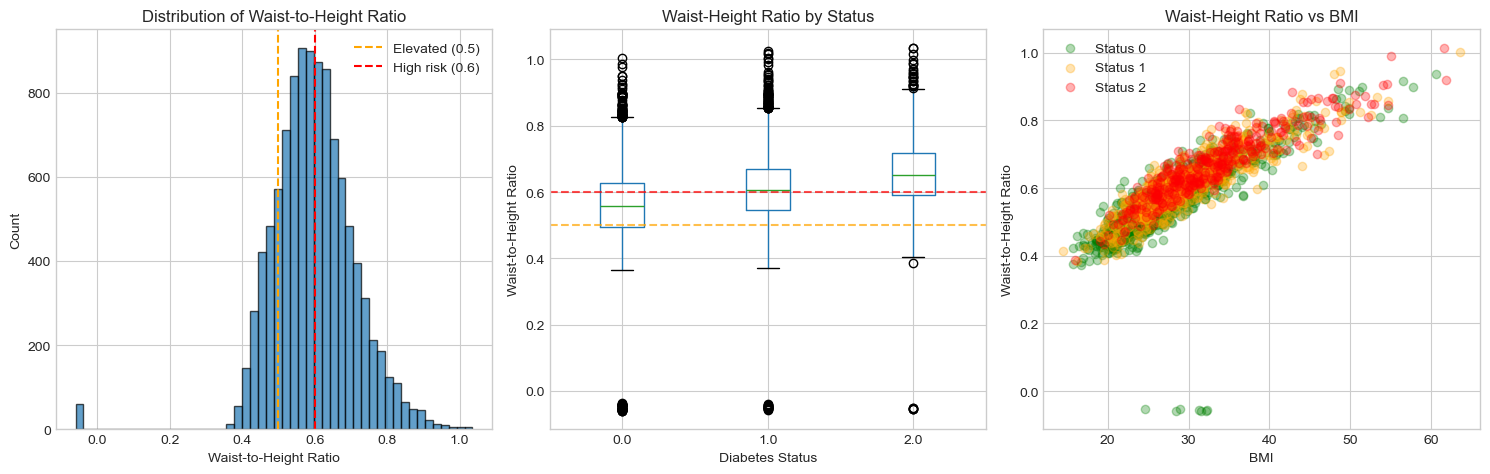


Waist-Height Ratio by Diabetes Status:
                  count   mean    std    min    25%    50%    75%    max
DIABETES_STATUS                                                         
0.0              4880.0  0.563  0.111 -0.060  0.495  0.558  0.627  1.004
1.0              3603.0  0.611  0.107 -0.056  0.547  0.607  0.669  1.025
2.0              1947.0  0.658  0.103 -0.055  0.590  0.652  0.718  1.036


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribution
ax = axes[0]
df_feat['WAIST_HEIGHT_RATIO'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0.5, color='orange', linestyle='--', label='Elevated (0.5)')
ax.axvline(0.6, color='red', linestyle='--', label='High risk (0.6)')
ax.set_xlabel('Waist-to-Height Ratio')
ax.set_ylabel('Count')
ax.set_title('Distribution of Waist-to-Height Ratio')
ax.legend()

# By diabetes status
ax = axes[1]
df_feat.boxplot(column='WAIST_HEIGHT_RATIO', by='DIABETES_STATUS', ax=ax)
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.7)
ax.axhline(0.6, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Waist-to-Height Ratio')
ax.set_title('Waist-Height Ratio by Status')
plt.suptitle('')

# Comparison with BMI
ax = axes[2]
sample = df_feat.sample(min(2000, len(df_feat)))
colors = {0: 'green', 1: 'orange', 2: 'red'}
for status in [0, 1, 2]:
    mask = sample['DIABETES_STATUS'] == status
    ax.scatter(sample.loc[mask, 'BMXBMI'], 
               sample.loc[mask, 'WAIST_HEIGHT_RATIO'],
               c=colors[status], alpha=0.3, label=f'Status {status}')
ax.set_xlabel('BMI')
ax.set_ylabel('Waist-to-Height Ratio')
ax.set_title('Waist-Height Ratio vs BMI')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_waist_height_validation.png', bbox_inches='tight')
plt.show()

print("\nWaist-Height Ratio by Diabetes Status:")
print(df_feat.groupby('DIABETES_STATUS')['WAIST_HEIGHT_RATIO'].describe().round(3))

### 3.5 Wake Time Difference (Social Jet Lag)

**Clinical Context:**
- "Social jet lag" disrupts circadian rhythms
- Associated with metabolic dysfunction and obesity
- Large differences (>2 hours) may indicate sleep debt

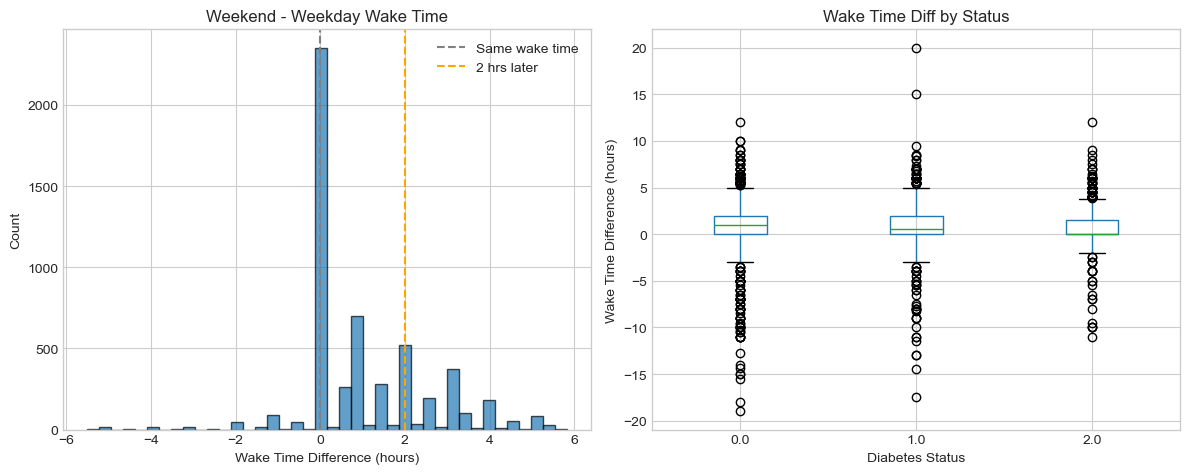


Wake Time Difference by Diabetes Status:
                  count  mean   std   min  25%  50%  75%   max
DIABETES_STATUS                                               
0.0              2690.0  1.08  2.35 -19.0  0.0  1.0  2.0  12.0
1.0              1889.0  0.96  2.08 -17.5  0.0  0.5  2.0  20.0
2.0              1122.0  0.74  1.78 -11.0  0.0  0.0  1.5  12.0


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution
ax = axes[0]
wake_diff = df_feat['WAKE_TIME_DIFF'].dropna()
wake_diff = wake_diff[(wake_diff > -6) & (wake_diff < 6)]  # Filter extreme values
wake_diff.hist(bins=40, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', label='Same wake time')
ax.axvline(2, color='orange', linestyle='--', label='2 hrs later')
ax.set_xlabel('Wake Time Difference (hours)')
ax.set_ylabel('Count')
ax.set_title('Weekend - Weekday Wake Time')
ax.legend()

# By diabetes status
ax = axes[1]
df_feat.boxplot(column='WAKE_TIME_DIFF', by='DIABETES_STATUS', ax=ax)
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Wake Time Difference (hours)')
ax.set_title('Wake Time Diff by Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_wake_time_validation.png', bbox_inches='tight')
plt.show()

print("\nWake Time Difference by Diabetes Status:")
print(df_feat.groupby('DIABETES_STATUS')['WAKE_TIME_DIFF'].describe().round(2))

### 3.6 Dietary Features (Water & Fat Quality)

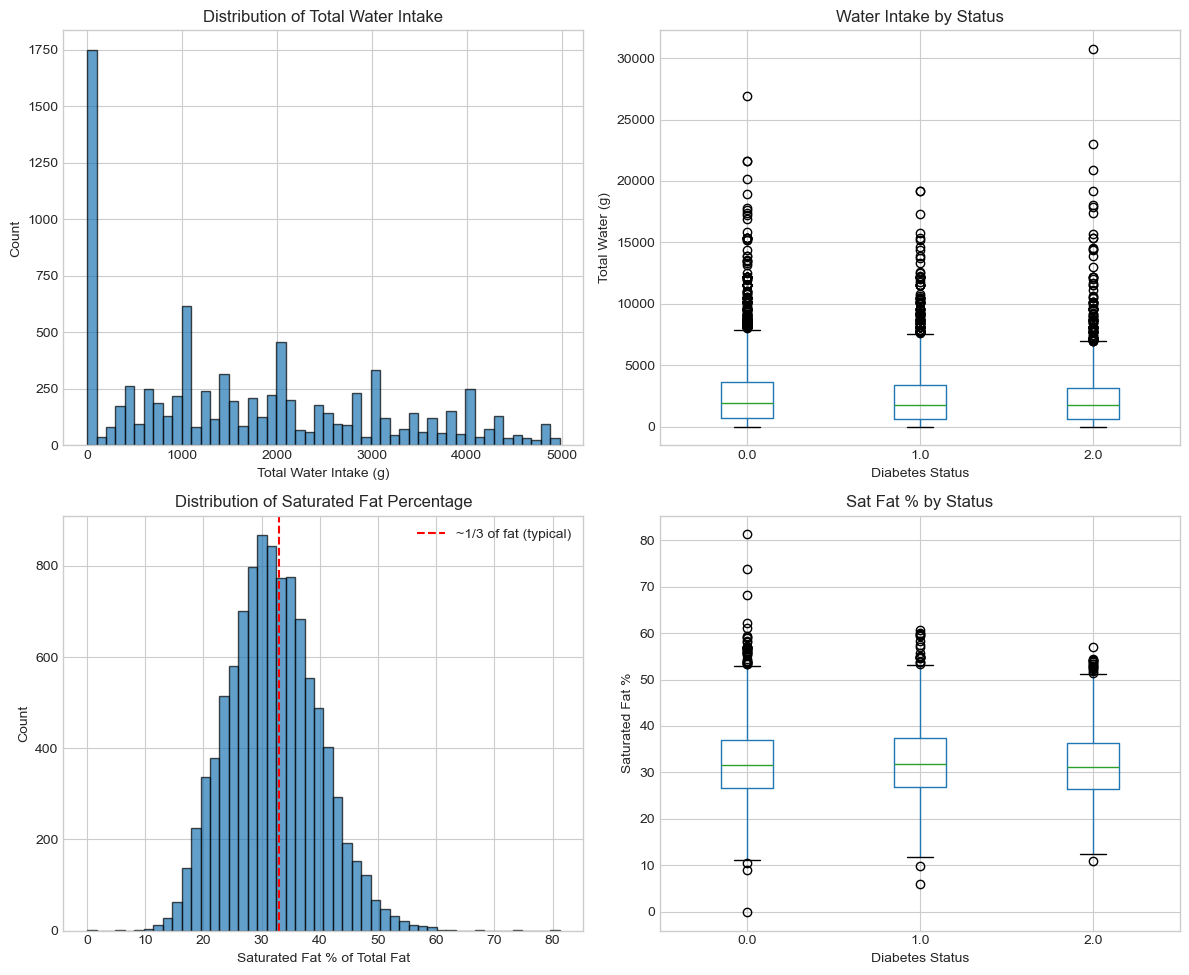

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Total water distribution
ax = axes[0, 0]
water = df_feat['TOTAL_WATER'].dropna()
water = water[water < 5000]  # Filter extreme
water.hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.set_xlabel('Total Water Intake (g)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Total Water Intake')

# Water by status
ax = axes[0, 1]
df_feat.boxplot(column='TOTAL_WATER', by='DIABETES_STATUS', ax=ax)
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Total Water (g)')
ax.set_title('Water Intake by Status')
plt.suptitle('')

# Saturated fat percentage distribution
ax = axes[1, 0]
df_feat['SAT_FAT_PCT'].dropna().hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(33, color='red', linestyle='--', label='~1/3 of fat (typical)')
ax.set_xlabel('Saturated Fat % of Total Fat')
ax.set_ylabel('Count')
ax.set_title('Distribution of Saturated Fat Percentage')
ax.legend()

# Sat fat by status
ax = axes[1, 1]
df_feat.boxplot(column='SAT_FAT_PCT', by='DIABETES_STATUS', ax=ax)
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Saturated Fat %')
ax.set_title('Sat Fat % by Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'derived_dietary_validation.png', bbox_inches='tight')
plt.show()

## 4. Define Feature Sets

We create two feature sets:
1. **with_labs**: All features including laboratory values (requires blood draw)
2. **without_labs**: Excludes lab values (for screening without blood tests)

In [11]:
# Get feature set definitions
feature_sets = get_feature_sets()

print("Feature Set Summary:")
print("=" * 60)
for name, info in feature_sets.items():
    print(f"\n{name.upper()}:")
    print(f"  Description: {info['description']}")
    print(f"  Total features: {info['n_features']}")
    if 'categories' in info:
        print("  By category:")
        for cat, count in info['categories'].items():
            print(f"    - {cat}: {count}")

Feature Set Summary:

WITH_LABS:
  Description: All features including laboratory values (requires blood draw)
  Total features: 109
  By category:
    - demographic: 2
    - anthropometric: 5
    - weight_history: 7
    - bp_exam: 11
    - bp_questionnaire: 5
    - dietary_nutrient: 19
    - dietary_behavior: 4
    - alcohol: 2
    - smoking: 3
    - physical_activity: 6
    - sleep: 7
    - cardiovascular: 1
    - medical_history: 10
    - depression: 10
    - laboratory: 17

WITHOUT_LABS:
  Description: Features excluding laboratory values (no blood draw required)
  Total features: 92
  By category:
    - demographic: 2
    - anthropometric: 5
    - weight_history: 7
    - bp_exam: 11
    - bp_questionnaire: 5
    - dietary_nutrient: 19
    - dietary_behavior: 4
    - alcohol: 2
    - smoking: 3
    - physical_activity: 6
    - sleep: 7
    - cardiovascular: 1
    - medical_history: 10
    - depression: 10

LAB_ONLY:
  Description: Laboratory features only
  Total features: 17


In [12]:
# Check feature availability in our data
for name in ['with_labs', 'without_labs']:
    features = feature_sets[name]['features']
    available, missing, stats = validate_feature_availability(df_feat, features)
    
    print(f"\n{name.upper()} Feature Availability:")
    print(f"  Requested: {stats['total_requested']}")
    print(f"  Available: {stats['available']}")
    print(f"  Missing: {stats['missing']}")
    if missing:
        print(f"  Missing features: {missing}")


WITH_LABS Feature Availability:
  Requested: 109
  Available: 109
  Missing: 0

WITHOUT_LABS Feature Availability:
  Requested: 92
  Available: 92
  Missing: 0


## 5. Feature Availability Analysis

Check missing rates for each feature in our defined sets.

In [13]:
# Calculate missing rates for with_labs features
with_labs_features = feature_sets['with_labs']['features']
available_features = [f for f in with_labs_features if f in df_feat.columns]

missing_rates = df_feat[available_features].isna().mean().sort_values(ascending=False)

# Show features with >10% missing
high_missing = missing_rates[missing_rates > 0.10]
print(f"Features with >10% missing ({len(high_missing)}):")
print(high_missing.to_string())

Features with >10% missing (65):
SMD650                 0.822486
BPQ100D                0.729335
SLEEP_DURATION_DIFF    0.724559
BPQ040A                0.641730
ALQ121                 0.615542
SMQ040                 0.594728
LBDLDL                 0.593705
TG_HDL_RATIO           0.592681
LBXTR                  0.589525
WAKE_TIME_DIFF         0.512582
SLD013                 0.509938
SLQ330_HOURS           0.509767
WHD130                 0.500299
ALQ130                 0.419176
WEIGHT_CHANGE_10YR     0.354346
CDQ010                 0.348460
WHD110                 0.289346
WEIGHT_CHANGE_25       0.240809
BPQ090D                0.239017
DBD900                 0.227587
WHD120                 0.149364
CARB_FIBER_RATIO       0.142882
SAT_FAT_PCT            0.135546
SUGAR_CARB_RATIO       0.135375
DR1TSFAT               0.135204
DR1TMFAT               0.135204
DR1TPFAT               0.135204
DR1_330Z               0.135204
DR1TCAFF               0.135204
DR1TALCO               0.135204
DR1_320

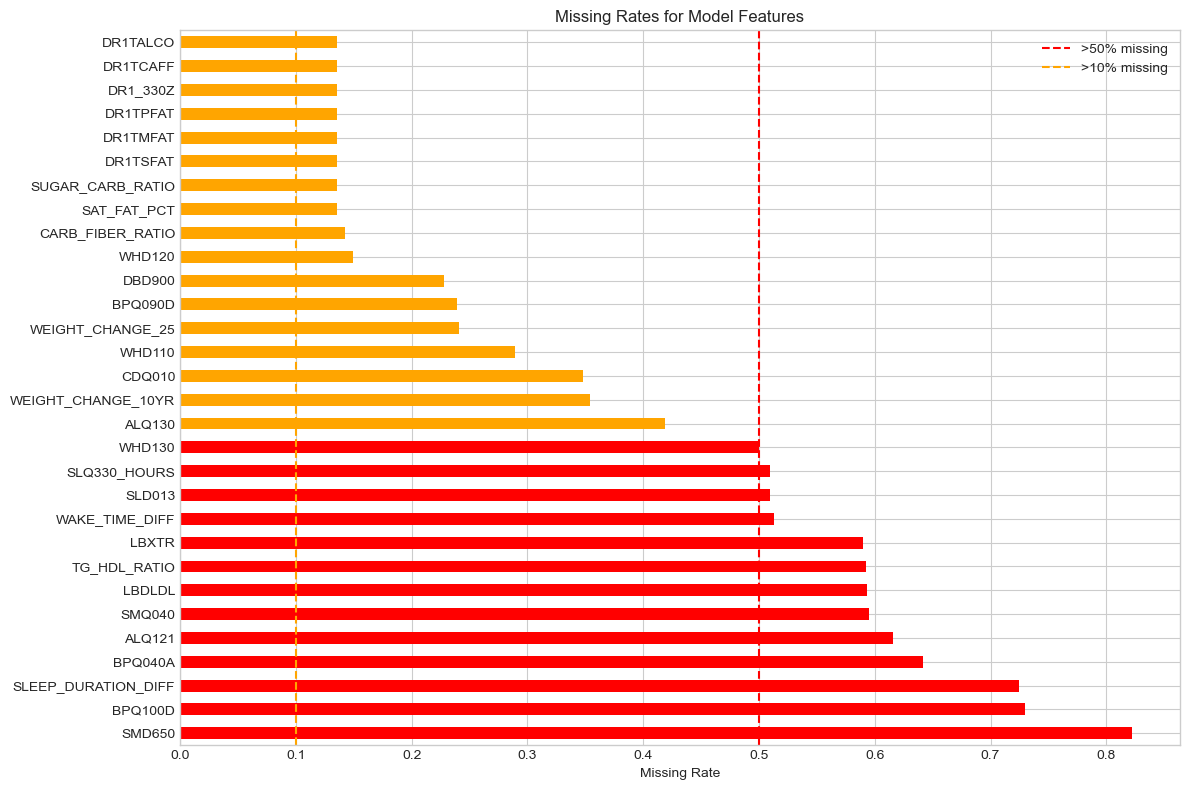

In [14]:
# Visualize missing rates
fig, ax = plt.subplots(figsize=(12, 8))

# Show top 30 features by missing rate
top_missing = missing_rates.head(30)
colors = ['red' if x > 0.5 else 'orange' if x > 0.1 else 'green' for x in top_missing]
top_missing.plot(kind='barh', ax=ax, color=colors)
ax.axvline(0.5, color='red', linestyle='--', label='>50% missing')
ax.axvline(0.1, color='orange', linestyle='--', label='>10% missing')
ax.set_xlabel('Missing Rate')
ax.set_title('Missing Rates for Model Features')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_missing_rates.png', bbox_inches='tight')
plt.show()

## 6. Prepare Final Datasets

Create 4 modeling-ready datasets:

| Dataset | Feature Set | Imputation | Use Case |
|---------|-------------|------------|----------|
| X_with_labs_minimal | with_labs | minimal (NaN preserved) | LightGBM |
| X_with_labs_full | with_labs | full (no NaN, >50% missing removed) | LogReg, MLP |
| X_without_labs_minimal | without_labs | minimal (NaN preserved) | LightGBM |
| X_without_labs_full | without_labs | full (no NaN, >50% missing removed) | LogReg, MLP |

In [15]:
# Create all 4 modeling datasets
datasets = create_all_modeling_datasets(
    df=df_feat,
    target_col='DIABETES_STATUS',
    output_dir=DATA_PROCESSED,
    max_missing_rate=0.50,  # Remove features with >50% missing for 'full' datasets
)

print("\nDataset Summary:")
print("=" * 70)
for name, (X, y, meta) in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {X.shape}")
    print(f"  Has NaN: {meta['has_nan']}")
    if meta['removed_high_missing']:
        print(f"  Removed high-missing features: {len(meta['removed_high_missing'])}")

2026-02-01 21:43:30,404 - INFO - 


2026-02-01 21:43:30,404 - INFO - Creating dataset: with_labs_minimal


2026-02-01 21:43:30,404 - INFO - ============================================================


2026-02-01 21:43:30,413 - INFO - Prepared with_labs_minimal dataset: 11698 samples, 109 features


2026-02-01 21:43:30,413 - INFO -   Shape: (11698, 109)


2026-02-01 21:43:30,413 - INFO -   Has NaN: True


2026-02-01 21:43:30,413 - INFO - 


2026-02-01 21:43:30,414 - INFO - Creating dataset: with_labs_full


2026-02-01 21:43:30,414 - INFO - ============================================================


2026-02-01 21:43:30,422 - INFO - Removing 13 features with >50% missing: ['WHD130', 'BPQ040A', 'BPQ100D', 'ALQ121', 'SMQ040', 'SMD650', 'SLD013', 'SLQ330_HOURS', 'WAKE_TIME_DIFF', 'SLEEP_DURATION_DIFF', 'LBDLDL', 'LBXTR', 'TG_HDL_RATIO']


2026-02-01 21:43:30,443 - INFO - Prepared with_labs_full dataset: 11698 samples, 96 features


2026-02-01 21:43:30,444 - INFO -   Shape: (11698, 96)


2026-02-01 21:43:30,444 - INFO -   Has NaN: False


2026-02-01 21:43:30,444 - INFO -   Removed 13 high-missing features


2026-02-01 21:43:30,444 - INFO - 


2026-02-01 21:43:30,444 - INFO - Creating dataset: without_labs_minimal


2026-02-01 21:43:30,445 - INFO - ============================================================


2026-02-01 21:43:30,450 - INFO - Prepared without_labs_minimal dataset: 11698 samples, 92 features


2026-02-01 21:43:30,450 - INFO -   Shape: (11698, 92)


2026-02-01 21:43:30,450 - INFO -   Has NaN: True


2026-02-01 21:43:30,450 - INFO - 


2026-02-01 21:43:30,451 - INFO - Creating dataset: without_labs_full


2026-02-01 21:43:30,451 - INFO - ============================================================


2026-02-01 21:43:30,455 - INFO - Removing 10 features with >50% missing: ['WHD130', 'BPQ040A', 'BPQ100D', 'ALQ121', 'SMQ040', 'SMD650', 'SLD013', 'SLQ330_HOURS', 'WAKE_TIME_DIFF', 'SLEEP_DURATION_DIFF']


2026-02-01 21:43:30,473 - INFO - Prepared without_labs_full dataset: 11698 samples, 82 features


2026-02-01 21:43:30,473 - INFO -   Shape: (11698, 82)


2026-02-01 21:43:30,473 - INFO -   Has NaN: False


2026-02-01 21:43:30,473 - INFO -   Removed 10 high-missing features


2026-02-01 21:43:30,623 - INFO - 
Saved all datasets to /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/data/processed



Dataset Summary:

with_labs_minimal:
  Shape: (11698, 109)
  Has NaN: True

with_labs_full:
  Shape: (11698, 96)
  Has NaN: False
  Removed high-missing features: 13

without_labs_minimal:
  Shape: (11698, 92)
  Has NaN: True

without_labs_full:
  Shape: (11698, 82)
  Has NaN: False
  Removed high-missing features: 10


In [16]:
# Datasets already created above - this cell is now unused

In [17]:
# Verify target distribution is preserved
_, y_with_labs, _ = datasets['with_labs_minimal']
print("Target Distribution:")
print(y_with_labs.value_counts().sort_index())
print(f"\nPercentages:")
print((y_with_labs.value_counts(normalize=True).sort_index() * 100).round(1))

Target Distribution:
DIABETES_STATUS
0.0    5684
1.0    3795
2.0    2219
Name: count, dtype: int64

Percentages:
DIABETES_STATUS
0.0    48.6
1.0    32.4
2.0    19.0
Name: proportion, dtype: float64


## 7. Save Processed Data

Datasets have been automatically saved by create_all_modeling_datasets().

Files created in `data/processed/`:
- `X_with_labs_minimal.parquet` - For tree models (LightGBM)
- `X_with_labs_full.parquet` - For linear models (LogReg, MLP)
- `X_without_labs_minimal.parquet` - For tree models without labs
- `X_without_labs_full.parquet` - For linear models without labs
- `y_*.parquet` - Target variables
- `metadata_*.json` - Feature metadata

In [18]:
# Save the full feature-engineered dataframe
df_feat.to_parquet(DATA_PROCESSED / 'features_engineered.parquet', index=True)
print(f"Saved: features_engineered.parquet ({df_feat.shape})")

# List all saved files
print("\nAll processed data files:")
for f in sorted(DATA_PROCESSED.glob('*.parquet')):
    print(f"  - {f.name}")

Saved: features_engineered.parquet ((11723, 1584))

All processed data files:
  - X_with_labs.parquet
  - X_with_labs_full.parquet
  - X_with_labs_minimal.parquet
  - X_without_labs.parquet
  - X_without_labs_full.parquet
  - X_without_labs_minimal.parquet
  - features_engineered.parquet
  - y_with_labs.parquet
  - y_with_labs_full.parquet
  - y_with_labs_minimal.parquet
  - y_without_labs.parquet
  - y_without_labs_full.parquet
  - y_without_labs_minimal.parquet


In [19]:
# Save consolidated feature engineering report
feature_report = {
    'derived_features': feature_stats,
    'datasets': {name: meta for name, (_, _, meta) in datasets.items()},
    'high_missing_features': missing_rates[missing_rates > 0.10].to_dict()
}

with open(DATA_PROCESSED / 'feature_engineering_report.json', 'w') as f:
    json.dump(feature_report, f, indent=2, default=str)
print("\nSaved: feature_engineering_report.json")


Saved: feature_engineering_report.json


## 8. Summary & Additional Feature Ideas

### Features Created

| Feature | Description | Clinical Value |
|---------|-------------|----------------|
| AVG_SYS_BP | Average systolic BP | More stable than single reading |
| AVG_DIA_BP | Average diastolic BP | More stable than single reading |
| TOTAL_WATER | Total water intake | Hydration affects glucose |
| ACR_RATIO | Albumin/creatinine ratio | Early kidney damage marker |
| WEIGHT_CHANGE_10YR | Weight change from 10 yrs ago | Recent weight trajectory |
| WEIGHT_CHANGE_25 | Weight change from age 25 | Lifetime weight gain |
| WEIGHT_FROM_MAX | Weight lost from maximum | Weight loss effort |
| WAKE_TIME_DIFF | Weekend-weekday wake difference | Social jet lag |
| WAIST_HEIGHT_RATIO | Waist/height ratio | Central obesity |
| SAT_FAT_PCT | Saturated fat % of total | Dietary fat quality |

### Additional Features to Consider (Future Work)

1. **Interaction features**: BMI × Age, Physical activity × Sedentary time
2. **PHQ-9 total score**: Sum of depression items
3. **Metabolic syndrome components**: Combine BP, waist, lipids
4. **Dietary quality scores**: HEI (Healthy Eating Index)
5. **Cardiovascular risk score**: Framingham-like composite

In [20]:
print("Phase 4: Feature Engineering Complete!")
print("="*60)
print(f"\nDerived features created: {len(feature_stats)}")
print(f"\n4 Modeling Datasets created in {DATA_PROCESSED}:")
for name, (X, y, meta) in datasets.items():
    print(f"  - X_{name}.parquet: {X.shape} (has_nan={meta['has_nan']})")
print(f"\nFigures saved to {FIGURES_DIR}")

Phase 4: Feature Engineering Complete!

Derived features created: 22

4 Modeling Datasets created in /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/data/processed:
  - X_with_labs_minimal.parquet: (11698, 109) (has_nan=True)
  - X_with_labs_full.parquet: (11698, 96) (has_nan=False)
  - X_without_labs_minimal.parquet: (11698, 92) (has_nan=True)
  - X_without_labs_full.parquet: (11698, 82) (has_nan=False)

Figures saved to /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/reports/figures
